In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed
/var/tmp/ipykernel_8814/490322424.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a = model.params[0]  # Intercept
/var/tmp/ipykernel_8814/490322424.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b = model.params[1]  # Slope
/var/tmp/ipykernel_8814/490322424.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

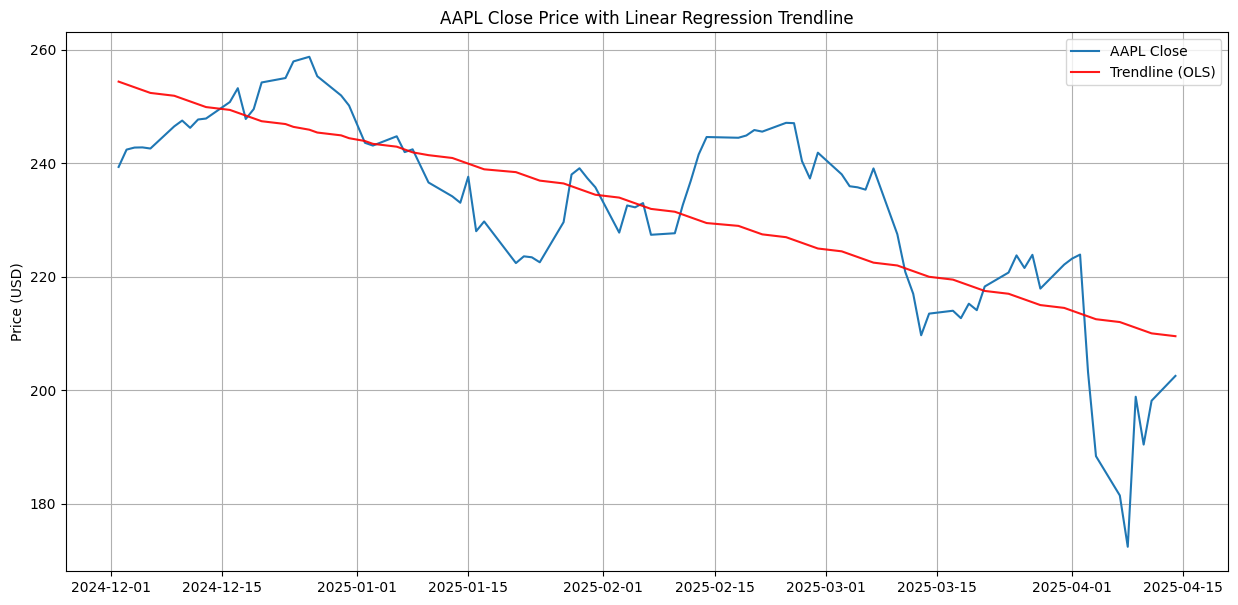

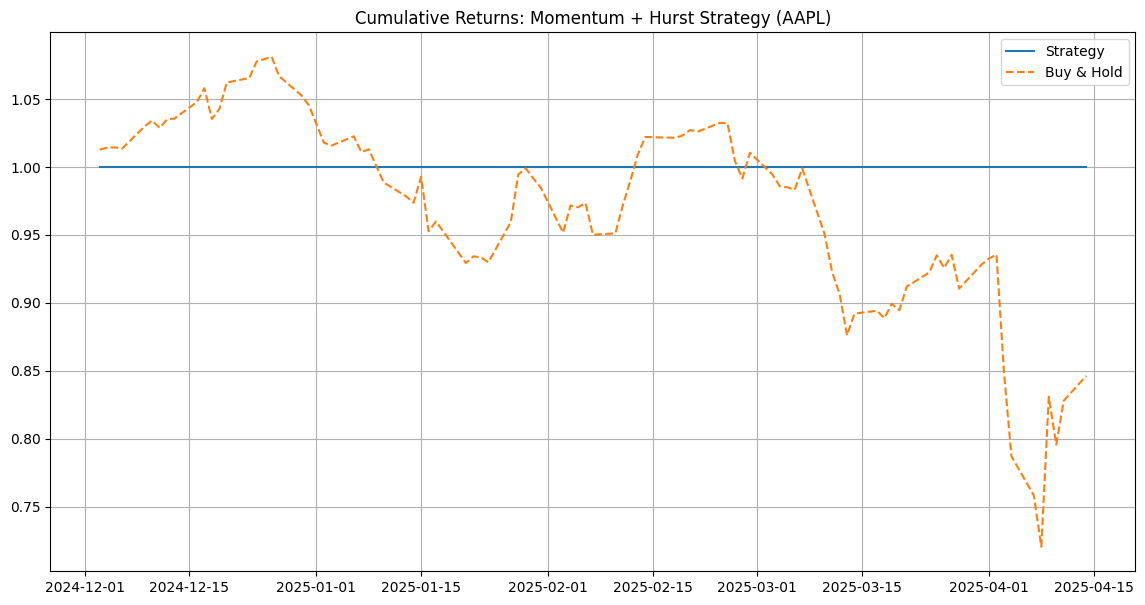

Strategy Final Return: 0.00%
Buy & Hold Return: -15.38%
Sharpe Ratio: nan


/var/tmp/ipykernel_8814/490322424.py:81: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.sqrt(252) * data['Strategy_Return'].mean() / data['Strategy_Return'].std()


In [8]:
# 1. IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import linregress
import statsmodels.api as sm


# 2. DOWNLOAD REAL DATA
data = yf.download('AAPL', start='2024-12-01', end='2025-04-15')
prices = data[['Close']]
dates = prices.index

# 3. PLOT PRICES
plt.figure(figsize=(15,7))
plt.plot(prices['Close'], label='AAPL Close')

# 4. LINEAR REGRESSION TRENDLINE
X = np.arange(len(dates))  # Days as numbers
x = sm.add_constant(X)     # Add constant term
model = sm.OLS(prices['Close'], x).fit()

# Get line coefficients
a = model.params[0]  # Intercept
b = model.params[1]  # Slope

# Predict trendline values
prices['Trendline'] = X * b + a

# 5. PLOT TRENDLINE
plt.plot(prices['Trendline'], color='red', alpha=0.9, label='Trendline (OLS)')
plt.ylabel('Price (USD)')
plt.title('AAPL Close Price with Linear Regression Trendline')
plt.legend()
plt.grid()
plt.show()

# 3. FEATURES
data['Momentum_10d'] = data['Close'].pct_change(10)

def calculate_hurst_fast(series):
    lags = np.arange(2, 20)
    tau = [np.std(series[lag:] - series[:-lag]) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = poly[0] * 2.0
    return hurst

data['Hurst_30d'] = data['Close'].rolling(window=30).apply(calculate_hurst_fast, raw=False)

# 4. GENERATE SIGNALS (vectorized version - NO apply, NO function!)

# Start with zero signals
data['Signal'] = 0

# Long when Momentum > 0 and Hurst > 0.5
data.loc[(data['Momentum_10d'] > 0) & (data['Hurst_30d'] > 0.3), 'Signal'] = 1
data.loc[(data['Momentum_10d'] < 0) & (data['Hurst_30d'] > 0.3), 'Signal'] = -1

# 5. STRATEGY RETURNS

data['Return'] = data['Close'].astype(float).pct_change()
data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()

# 6. BUY & HOLD RETURNS
data['Cumulative_BuyHold'] = (1 + data['Return']).cumprod()

# 7. PLOT
plt.figure(figsize=(14,7))
plt.plot(data.index, data['Cumulative_Strategy'], label='Strategy')
plt.plot(data.index, data['Cumulative_BuyHold'], label='Buy & Hold', linestyle='--')
plt.title('Cumulative Returns: Momentum + Hurst Strategy (AAPL)')
plt.legend()
plt.grid()
plt.show()

# 8. PERFORMANCE
final_return = data['Cumulative_Strategy'].iloc[-1] - 1
buyhold_return = data['Cumulative_BuyHold'].iloc[-1] - 1
sharpe_ratio = np.sqrt(252) * data['Strategy_Return'].mean() / data['Strategy_Return'].std()

print(f"Strategy Final Return: {final_return:.2%}")
print(f"Buy & Hold Return: {buyhold_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")